# Transformer로 번역기 만들기

## 1. 들어가며

### 준비물

- 터미널을 열고 프로젝트를 위한 디렉토리를 생성해 주세요.
`$ mkdir -p ~/aiffel/transformer`

-  한국어가 포함된 말뭉치를 사용하므로, 한국어를 잘 시각화하기 위한 준비가 필요합니다. 터미널에서 나눔 글꼴을 설치합니다.
`$ sudo apt -qq -y install fonts-nanum`

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

## 2. 내부 모듈 구현하기

- 이번 코스는 트랜스포머를 완성하는 데에 필요한 모듈들을 하나하나 만든 후, 조립하여 완성하는 방식으로 진행할 겁니다.
- Tensor로 변환한 입력 데이터가 주어졌다고 가정하고 흐름을 생각해 봅시다.
1. 입력 데이터 → [ batch_size x length ]
2. Source & Target Embedding → [ batch_size x length x d_emb ]
3. __Positional Encoding__ 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.
4. __Multi-Head Attention__ 아래와 같이 여러 개의 서브 모듈들이 존재합니다.<br>
    1) Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ]<br>
    2) Masking for Masked Attention<br>
    3) Scaled Dot Product Attention<br>
    4) Combine Heads →[ batch_size x length x d_emb ]<br>
5. Residual Connection
6. Layer Normalization
7. __Position-wise Feed-Forward Network__ → [ batch_size x length x d_ff ]
8. Output Linear Layer → [ batch_size x length x vocab_size ]
- 굵게 표시된 모듈을 제외하면 나머지는 텐서플로우 내부에 이미 구현체가 포함되어 있어서 간단하게 사용할 수 있습니다.

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.4.1


### Positional Encoding
![Positional Encoding](https://wikidocs.net/images/page/31379/transformer7.PNG)
$$PE_{(pos,2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)}=cos(pos/10000^{2_i/d_{model}})$$

In [3]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


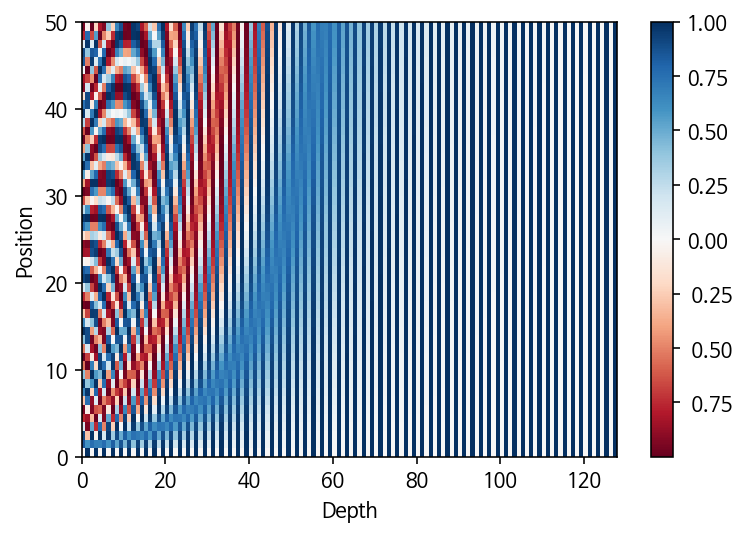

In [4]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = positional_encoding(50, 128)

plt.pcolormesh(sample_pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Multi-Head Attention

- Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성됩니다. 
- Embedding된 입력을 Head 수로 분할하는 split_heads()
- 분할된 입력으로부터 Attention 값을 구하는 scaled_dot_product_attention()
- 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜주는 combine_heads()
-  Masking 부분은 마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 MultiHeadAttention 외부에 정의해줄것입니다.
- 대신 생성된 마스크를 처리할 수 있도록 scaled_dot_product_attention() 에는 아래 한 줄을 포함해줍니다.

```
#scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
if mask is not None: scaled_qk += (mask * -1e9)
```

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        # padding_mask : (batch_size, 1, 1, key의 문장 길이)
    
        d_k=tf.cast(K.shape[-1], tf.float32)
        # Q와 K의 곱. 어텐션 스코어 행렬.
        QK = tf.matmul(Q, K, transpose_b=True)
        # 스케일링
        scaled_qk = QK/tf.math.sqrt(d_k)

        # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
        # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
        if mask is not None: scaled_qk += (mask * -1e9)

        # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
        # attention weight(attentions) : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # output(out) : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        out = tf.matmul(attentions, V) 

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, self,depth))
        split_x = tf.transpose(x, perm=[0,2,1,3])
        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)    
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### Position-wise Feed-Forward Network

In [6]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

## 3. 모듈 조립하기
- 이제 Encoder 한 층과 Decoder 한 층을 각각 완성하였습니다.
- 실험이 가능하게 하려면 모델이 동적으로 완성될 수 있게끔 해야 합니다.
- 마치 텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 tf.keras.layers.Layer 클래스를 상속받아 레이어 클래스로 정의해 주면 됩니다.

```
N = 10

# 10개의 Linear Layer를 한 방에!
linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# 10개의 Encoder Layer도 한 방에!
enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]
```

### Encoder 레이어 구현하기

1. 잔차연결(Residual connection)
- 잔차연결은 CV분야에서 주로 사용되는 모델의 학습을 돕는 기법입니다.
$$H(x)=x+SubLayer(x)$$

2. 층 정규화(Layer Normalization)
- 텐서의 마지막 차원에 대해서 평균과 분산을 구하고, 이를 가지고 특정 수식을 통해 값을 정규화하여 학습을 돕습니다.
$$LN = LayerNorm(x+SubLayer(x))$$
- 벡터 $x_i$를 정규화 해줍니다. 벡터 $x_i$의 각 차원을 $k$라고 하였을 때, $x_{i,k}$는 다음의 수식과 같이 정규화 할 수 있습니다.
$$\hat{x_{i,k}}=\frac{x_{i,k}-\mu_{i}}{\sqrt{\sigma^2_i+\epsilon}}$$
- $\epsilon$은 분모가 0이 되는 것을 방지하는 값입니다.
- 이제 $\gamma$과 $\beta$라는 벡터를 준비합니다. 이들의 초기값은 각각 1과 0입니다.
- $\gamma$와 $\beta$를 도입한 층 정규화의 최종 수식은 다음과 같으며, 와 는 학습 가능한 파라미터입니다.
$$ln_i=\gamma\hat{x}_i+\beta=LayerNorm(x_i)$$

In [7]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

- 인코더의 입력으로 들어가는 문장에는 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크를 사용합니다. 
- 인코더는 총 두 개의 서브층으로 이루어지는데, 멀티 헤드 어텐션과 피드 포워드 신경망입니다. 각 서브층 이후에는 드롭 아웃, 잔차 연결과 층 정규화가 수행됩니다.
- 위 코드는 하나의 하나의 인코더 층을 구현하는 코드입니다. 트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드를 추가로 구현해줄 필요가 있습니다.
- Transformer의 구현은 정말 많은데, 그중에서 Normalization Layer의 위치에 대한 논의가 종종 나온답니다.
- 실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식을 사용했어요.
- 트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)이라는 제목의 논문이 2020년 초반에 발표되었습니다. 이 논문에서는 모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 왜 유리한지를 설명하고 있습니다.

### Decoder 레이어 구현하기
1. 디코더의 첫번째 서브 층: 셀프 어텐션과 룩-어헤드 마스크
- Transformer는 문장을 한번에 입력 받기 때문에, 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 합니다.
- 셀프 어텐션을 통해 어텐션 스코어 행렬을 얻은후, 마스킹을 하는 방식으로 동작합니다.

2. 디코더의 첫번째 서브 층: 인코더-디코더 어텐션
- 멀티 헤드 어텐션을 수행한다는 점에서는 이전의 어텐션들과 같지만, 셀프어텐션은 아닙니다.
- 셀프 어텐션은 Query, Key, Value (의 출처)가 같은 경우를 말하는데, 인코더-디코더 어텐션은 Query가 디코더 행렬이고, Key와 Value는 인코더 행렬이기 때문입니다.

In [8]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention (Decoder-Encoder Attention)
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

- 디코더는 총 세 개의 서브층으로 구성됩니다. 
- 첫번째와 두번째 서브층 모두 멀티 헤드 어텐션이지만, 첫번째 서브층은 mask의 인자값으로 ~~look_ahead_mask~~ padding_mask가 들어가는 반면, 두번째 서브층은 mask의 인자값으로 ~~padding_mask~~ causality_mask가 들어가는 것을 확인할 수 있습니다. 
- 이는 첫번째 서브층은 마스크드 셀프 어텐션을 수행하기 때문입니다. 세 개의 서브층 모두 서브층 연산 후에는 드롭 아웃, 잔차 연결, 층 정규화가 수행되는 것을 확인할 수 있습니다.

EncodeLayer 와 DecoderLayer 를 모두 정의했으니 이를 이용해 Encoder와 Decoder 클래스를 정의하여 조립합니다.

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer 완성하기

- `shared` 변수를 매개변수로 받아 `True` 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model)을 곱해줘야 합니다. (참고: `tf.keras.layers.Layer.set_weights()`)

- 우리가 정의한 `positional_encoding` 의 반환값 형태는 `[ Length x d_model ]` 인데, 이를 더해 줄 Embedding 값 형태가 `[ Batch x Length x d_model ]` 이라서 연산이 불가능합니다. 연산이 가능하도록 수정합니다. (참고: `tf.expand_dims()`, `np.newaxis`)

In [11]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layer.Dropout(dropout)
        
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        self.shared = shared
        
        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## 4. 모델 밖의 조력자들

- 이번 스텝에서는 데이터의 특성이나 학습 과정에 따라 달라지는 부분을 다루게 됩니다.

### Masking

- `generate_padding_mask()` 는 Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다. 
- 한 배치의 데이터에서 <PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다.

In [12]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

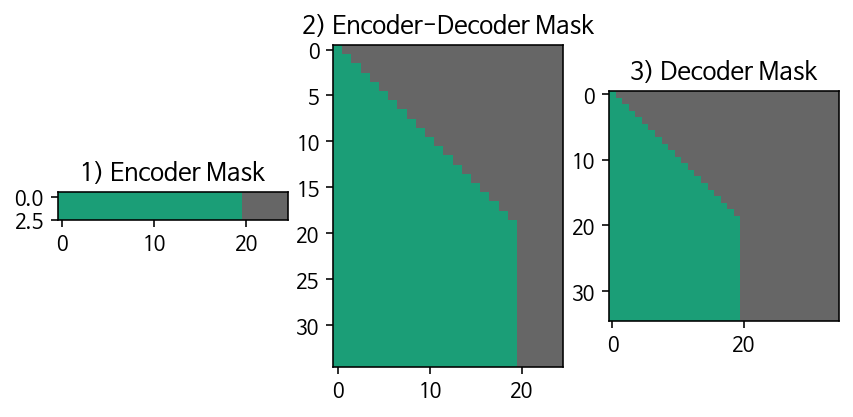

In [13]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

- 첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다. 
- 낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데 Causality Mask와 Padding Mask를 결합한 형태입니다.
- 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 했던 것을 기억하시죠? 인과 관계를 가리는 것도 중요하지만 Decoder 역시 <PAD> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된답니다.

###  Learning Rate

- 트랜스포머는 고정된 Learning Rate를 사용하지 않았습니다.
- 논문의 해당 부분을 Optimizer까지 포함하여 다시 한번 살펴봅시다. 
- Tensorflow 상에서 잘 구동될 수 있도록 LearningRateSchedule 클래스를 상속받아 구현해봅시다.

In [14]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

# 프로젝트: Transformer를 이용한 번역기 만들기

## Step 1. 데이터 다운로드 (클라우드 유저용)
- 사용할 데이터: [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

## Step 2. 데이터 정제 및 토큰화

1) set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [16]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [18]:
len(cleaned_corpus)

78968

2) 정제 함수를 아래 조건을 만족하게 정의하세요.
- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [ ]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower()
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence) #a-zA-Z?.!, 제외한 문자 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #단어와 구두점 사이의 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백 여러개 하나의 공백으로 치환
    sentence = sentence.strip()
    
    return sentence

3) 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 
- 토큰화에는 Sentencepiece를 활용하세요. 
- [공식 사이트](https://github.com/google/sentencepiece)를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 
> - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
> - 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
> - 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.<BR> \<PAD\> : 0 / \<BOS\> : 1 / \<EOS\> : 2 / \<UNK\> : 3
- 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. 
- en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

In [22]:
!pip install sentencepiece
!wget https://raw.githubusercontent.com/google/sentencepiece/master/data/botchan.txt

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
--2021-10-27 12:45:51--  https://raw.githubusercontent.com/google/sentencepiece/master/data/botchan.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278779 (272K) [text/plain]
Saving to: ‘botchan.txt’

botchan.txt         100%[===================>] 272.25K  --.-KB/s    in 0.03s   

2021-10-27 12:45:51 (9.41 MB/s) - ‘botchan.txt’ saved [278779/278779]



In [ ]:
import sentencepiece as spm

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    spm.SentencePieceTrainer.train(f'--input=botchan.txt --model_prefix=m --vocab_size={vocab_size}')
    
    sp = spm.SentencePieceProcessor()
    sp.load('m.model')
    
    print('bos=', sp.bos_id())
    print('eos=', sp.eos_id())
    print('unk=', sp.unk_id())
    print('pad=', sp.pad_id())
    
    
    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

## 정리

### 루브릭

|평가문항|	상세기준|
|:---|:---|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|
|2. Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|